In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
 
df = pd.read_csv("/gdrive/My Drive/전산통계/원본 자료/souvenior_sales.csv")
print(df.head())

     sales
0  1664.81
1  2397.53
2  2840.71
3  3547.29
4  3752.96


In [18]:
start = 1987
month = []
while start < 1994:
    for i in range(1, 13):
        if i < 10:
            month.append(str(start) + "-0" + str(i))
        else:
            month.append(str(start) + "-" + str(i))
    start += 1

In [19]:
month[-1]

'1993-12'

In [20]:
df['month'] = month

In [21]:
df.head()

,sales,month
0,1664.81,1987-01
1,2397.53,1987-02
2,2840.71,1987-03
3,3547.29,1987-04
4,3752.96,1987-05


In [22]:
df = df[['month', 'sales']]

In [23]:
df.head()

,month,sales
0,1987-01,1664.81
1,1987-02,2397.53
2,1987-03,2840.71
3,1987-04,3547.29
4,1987-05,3752.96


In [25]:
df.month = pd.to_datetime(df.month)
print(df.head())
df.set_index('month', inplace=True)

       month    sales
0 1987-01-01  1664.81
1 1987-02-01  2397.53
2 1987-03-01  2840.71
3 1987-04-01  3547.29
4 1987-05-01  3752.96


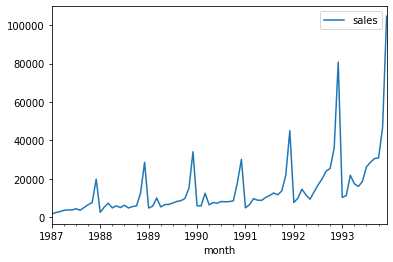

In [27]:
df.plot()

## 성분 분해

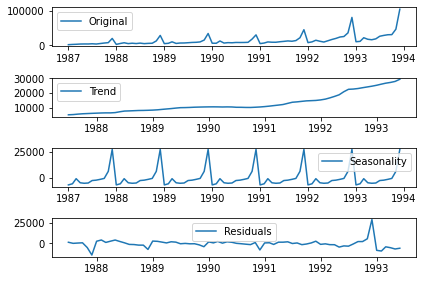

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
y = df['sales']
y = y.astype(float)
decomposition = seasonal_decompose(y)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

## stationary 검증

H0 : It is not stationary

In [57]:
from statsmodels.tsa.stattools import adfuller
res_test = adfuller(y)
print('ADF Statistic : %f' % res_test[0])
print('p-value : %f' % res_test[1])
print('Critical Value : %s' % res_test[4])
print(res_test) # Don't reject H0

ADF Statistic : 2.316542
p-value : 0.998965
Critical Value : {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}
(2.3165420725442982, 0.9989654526268575, 12, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, 1392.4239733870877)


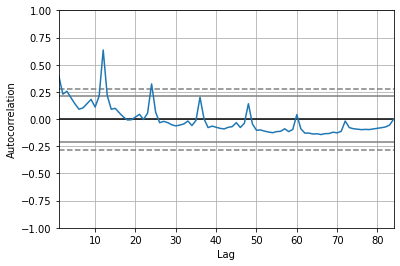

In [58]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

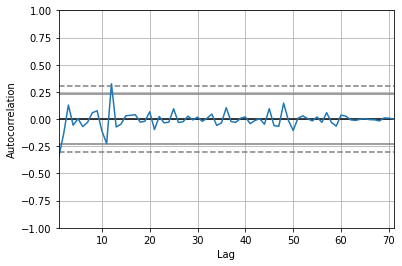

In [59]:
y_tran = y.diff(1)
y_tran = y_tran.diff(12)
autocorrelation_plot(y_tran.dropna())

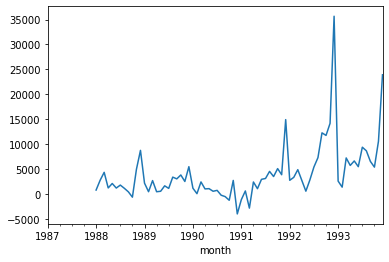

In [60]:
y12 = y.diff(12)
y12.plot()

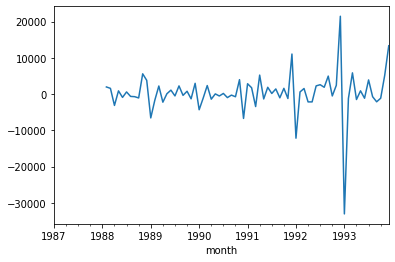

In [61]:
y12_1 = y12.diff(1)
y12_1.plot()

In [62]:
y

month
1987-01-01      1664.81
1987-02-01      2397.53
1987-03-01      2840.71
1987-04-01      3547.29
1987-05-01      3752.96
                ...    
1993-08-01     28586.52
1993-09-01     30505.41
1993-10-01     30821.33
1993-11-01     46634.38
1993-12-01    104660.67
Name: sales, Length: 84, dtype: float64

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import datetime

y_train = y[:'1992-01-01']
y_test = y['1992-02-01':]

model = SARIMAX(y_train, order=(0,1,1), seasonal_order=(0,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -449.483
Date:                            Tue, 10 Nov 2020   AIC                            904.965
Time:                                    08:43:20   BIC                            910.579
Sample:                                01-01-1987   HQIC                           907.087
                                     - 01-01-1992                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6059      0.094     -6.417      0.000      -0.791      -0.421
ma.S.L12       0.1055      0.100   

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


## grid search 통한 모델 선택

In [66]:
pdq = []
seasonal_pdq = []

for p in range(0,2):
    for d in range(0,2):
        for q in range(0,2):
            a1 = (p,d,q)
            a2 = (p,d,q,12)
            pdq.append(a1)
            seasonal_pdq.append(a2)

pdq = list(pdq)
print(pdq)
seasonal_pdq = list(seasonal_pdq)
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [67]:
import sys
import numpy as np
import statsmodels.api as sm

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_model = sm.tsa.statespace.SARIMAX(df.sales, order = param, seasonal_order = param_seasonal, enforce_stationarity=True, enforce_invertibility=True)
            res = tmp_model.fit()

            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = tmp_model
        except:
            print("unexpected error:", sys.exc_info()[0])
            continue

print("Best SARIMAX {} X {}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, Va

unexpected error: <class 'numpy.linalg.LinAlgError'>


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python

unexpected error: <class 'numpy.linalg.LinAlgError'>


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python

Best SARIMAX (1, 1, 1) X (1, 1, 0, 12)12 model - AIC:1396.8899105510975


#### 최적 모델 선정

Best SARIMAX (1, 1, 1) X (1, 1, 0, 12)12 model - AIC:1396.8899105510975

In [71]:
model = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,0,12))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -694.445
Date:                            Tue, 10 Nov 2020   AIC                           1396.890
Time:                                    08:46:41   BIC                           1405.941
Sample:                                01-01-1987   HQIC                          1400.489
                                     - 12-01-1993                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2862      0.132      2.175      0.030       0.028       0.544
ma.L1         -0.9011      0.065   

In [81]:
y_train = y[:'1992-01-01']
y_test = y['1992-02-01':]

model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,0,12))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                   61
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -449.100
Date:                            Tue, 10 Nov 2020   AIC                            906.200
Time:                                    08:57:54   BIC                            913.685
Sample:                                01-01-1987   HQIC                           909.029
                                     - 01-01-1992                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1577      0.158     -0.999      0.318      -0.467       0.152
ma.L1         -0.4917      0.198   

## 매출 예측

In [82]:
start_index = datetime(1992, 2, 1)
end_index = datetime(1998, 1, 1)
forecast = results.forecast(72)
forecast

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


1992-02-01    14087.003281
1992-03-01    15881.280719
1992-04-01    16189.497119
1992-05-01    15813.797484
1992-06-01    17666.309823
                  ...     
1997-09-01    61625.819211
1997-10-01    63976.431462
1997-11-01    71897.805146
1997-12-01    97789.210671
1998-01-01    57421.795342
Freq: MS, Length: 72, dtype: float64

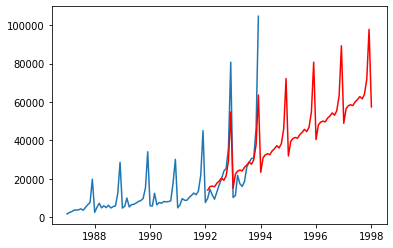

In [84]:
plt.plot(y)
# start_index = datetime(1992, 1, 1)
# end_index = datetime(1998, 1, 1)
plt.plot(results.forecast(72), color = 'red')